In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.metrics import PredictionErrorDisplay, r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from neural import *
from dataset import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# load data plus some additional preprocessing
input_features = []
output_labels = []
with open(f"playerData_features.txt", mode="r",encoding="utf-8") as file:
    num_no_prenhl_seasons = 0
    for line in file:
        player_data = json.loads(line.strip())

        player_input_features = []
        player_output_labels = []

        # multihot encode position
        position_mapping = {"C": [0], "LW": [1], "RW": [2], "D": [3], "W": [1,2], "F": [0,1,2]}
        positions = [0] * 4
        for pos in player_data.get("detailedPosition"):
            for i in position_mapping[pos]:
                    positions[i] = 1
        player_input_features.extend(positions)

        left_right_mapping = {"L": 0, "R": 1, "N": 0.5}  # N for neither or unknown
        player_input_features.append(left_right_mapping[player_data.get("shoots") if player_data.get("shoots") else "N"])

        # if player_data.get("height"):
        #     player_input_features.append(player_data.get("height"))
        # else:
        #     continue
        # if player_data.get("weight"):
        #     player_input_features.append(player_data.get("weight"))
        # else:
        #     continue

        nhl_seasons = torch.zeros(4, dtype=torch.float32)
        num_nhl_seasons = 0
        nonnhl_seasons = torch.zeros(4, dtype=torch.float32)
        num_nonnhl_seasons = 0
        
        nonnhl_plusMinus = 0
        num_nonnhl_plusMinus = 0
        most_recent_season = 0
        # average stats for nhl seasons and non nhl seasons
        for season in player_data.get("seasonStats", []):
            if int(season.get("year","0-0").split('-')[1]) > most_recent_season:
                most_recent_season = int(season.get("year","0-0").split('-')[1])
            # maybe could add year later
            # could use normal plus minus instead of per game
            season_data = torch.tensor([season.get("gamesPlayed_log"), season.get("goalsPerGame"), season.get("assistsPerGame"), season.get("penaltyMinsPerGame")], dtype=torch.float32) # , season.get("pointsPerGame"), , season.get("plusMinus")
            if season.get("league", "") == "NHL":
                nhl_seasons += season_data
                num_nhl_seasons += 1
            else:
                nonnhl_seasons += season_data
                num_nonnhl_seasons += 1
                if season.get("plusMinus"):
                    nonnhl_plusMinus+=int(season.get("plusMinus"))
                    num_nonnhl_plusMinus +=1

        if num_nonnhl_seasons == 0:
            num_no_prenhl_seasons += 1
            continue

        if most_recent_season < 1980:
            continue
        # average stats over all seasons
        nhl_seasons /= num_nhl_seasons if num_nhl_seasons > 0 else 1
        nonnhl_seasons /= num_nonnhl_seasons if num_nonnhl_seasons > 0 else 1

        player_input_features.append(num_nonnhl_seasons)
        player_input_features.extend(nonnhl_seasons.tolist())
        # add average plus minus
        if num_nonnhl_plusMinus:
            player_input_features.append(nonnhl_plusMinus/num_nonnhl_plusMinus)
        else:
            player_input_features.append(0)
        player_output_labels.extend(nhl_seasons.tolist()[1:3])
        # player_output_labels.extend(nhl_seasons.tolist())


        input_features.append(player_input_features)
        output_labels.append(player_output_labels)

print(f"number of players with no non NHL seasons: {num_no_prenhl_seasons}")
print(f"number of samples: {len(input_features)}")

print("numInputFeatures:", len(input_features[0]))
print("numOutputLabels:", len(output_labels[0]))


train_dataset = NHLDataset(input_features[:-800], output_labels[:-800])
validation_dataset = NHLDataset(input_features[-800:-400], output_labels[-800:-400])
test_dataset = NHLDataset(input_features[-400:], output_labels[-400:])


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


number of players with no non NHL seasons: 743
number of samples: 4013
numInputFeatures: 11
numOutputLabels: 2


In [3]:
# model definition

model = MLP(input_size=11, output_size=2, hidden_size=50, num_hidden_layers=3, dropout_rate=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)
criterion = nn.MSELoss()

print(model)
print(f"number of parameters: {sum(p.numel() for p in model.parameters())}")

train_losses, validation_losses = [], [] 
cur_epoch = 0
best_val_loss = float('inf')
best_epoch = 1
model_save_path = "best_model.pth"

def trainModel(model: nn.Module, dataloader: torch.utils.data.DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device) -> float:
    # trains the model for one epoch
    # return average loss over epoch
    model.train()
    totalLoss = 0
    n = len(dataloader)
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)

        totalLoss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return totalLoss/n

def evaluateModel(model: nn.Module, dataloader: torch.utils.data.DataLoader, criterion: nn.Module, device: torch.device,) -> float:
    # evaluates the model
    # return average loss
    model.eval()
    totalLoss = 0
    n = len(dataloader)
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        
        totalLoss += loss.item()
    return totalLoss/n



MLP(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=50, out_features=2, bias=True)
  )
)
number of parameters: 8752


In [4]:
# Training loop with model saving

num_epochs = 300
for _ in range(num_epochs):
    train_loss = trainModel(model, train_loader, criterion, optimizer, device)
    validation_loss = evaluateModel(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    cur_epoch += 1

    # Save model if validation loss improved
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_epoch = cur_epoch
        torch.save({
            'epoch': cur_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'validation_loss': validation_loss,
            'train_losses': train_losses,
            'validation_losses': validation_losses,
        }, model_save_path)
        print(f"Epoch {cur_epoch}| Train Loss: {train_loss:.4f}| Validation Loss: {validation_loss:.4f} [Model Saved]")
    else:
        print(f"Epoch {cur_epoch}| Train Loss: {train_loss:.4f}| Validation Loss: {validation_loss:.4f}")

print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
print(f"Best model saved to: {model_save_path}")

Epoch 1| Train Loss: 0.3275| Validation Loss: 0.0350 [Model Saved]
Epoch 2| Train Loss: 0.3063| Validation Loss: 0.0338 [Model Saved]
Epoch 3| Train Loss: 0.2673| Validation Loss: 0.0281 [Model Saved]
Epoch 4| Train Loss: 0.2566| Validation Loss: 0.0262 [Model Saved]
Epoch 5| Train Loss: 0.2239| Validation Loss: 0.0232 [Model Saved]
Epoch 6| Train Loss: 0.2102| Validation Loss: 0.0224 [Model Saved]
Epoch 7| Train Loss: 0.1947| Validation Loss: 0.0237
Epoch 8| Train Loss: 0.1790| Validation Loss: 0.0200 [Model Saved]
Epoch 9| Train Loss: 0.1606| Validation Loss: 0.0200 [Model Saved]
Epoch 10| Train Loss: 0.1665| Validation Loss: 0.0194 [Model Saved]
Epoch 11| Train Loss: 0.1407| Validation Loss: 0.0180 [Model Saved]
Epoch 12| Train Loss: 0.1330| Validation Loss: 0.0170 [Model Saved]
Epoch 13| Train Loss: 0.1278| Validation Loss: 0.0175
Epoch 14| Train Loss: 0.1199| Validation Loss: 0.0180
Epoch 15| Train Loss: 0.1137| Validation Loss: 0.0162 [Model Saved]
Epoch 16| Train Loss: 0.1053| V

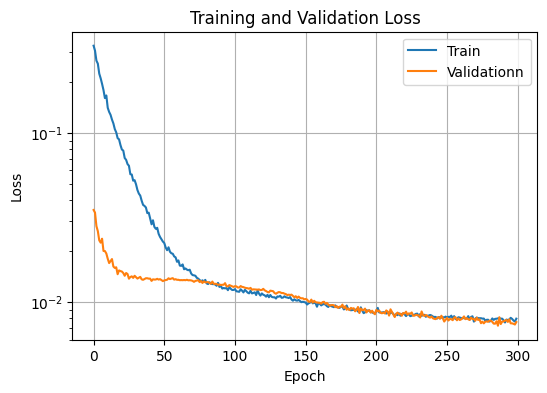


Metrics - Training

Performance Metrics:
Mean Squared Error (MSE):        0.006879
Root Mean Squared Error (RMSE): 0.081779
Mean Absolute Error (MAE):      0.060758
R² Score (Coefficient of Determination): 0.477375

Metrics - Validation

Performance Metrics:
Mean Squared Error (MSE):        0.007137
Root Mean Squared Error (RMSE): 0.083567
Mean Absolute Error (MAE):      0.063282
R² Score (Coefficient of Determination): 0.477056

Metrics - Testing

Performance Metrics:
Mean Squared Error (MSE):        0.008057
Root Mean Squared Error (RMSE): 0.088990
Mean Absolute Error (MAE):      0.066733
R² Score (Coefficient of Determination): 0.383762


In [ ]:
# plot training and validation loss
plt.figure(figsize=(6, 4))
plt.title(f"Training and Validation Loss")
plt.plot(train_losses, label=f"Train")
plt.plot(validation_losses, label=f"Validationn")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.semilogy()
plt.grid(True)
plt.legend()
plt.show()


def print_metrics(model, dataloader, device):
    model.eval()
    allPreds, trueOutputs = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            allPreds.extend(preds.cpu().numpy())
            trueOutputs.extend(y.cpu().numpy())
        
        # x = PredictionErrorDisplay(y_true= np.array(trueOutputs), y_pred= np.array(trueOutputs))
        # x.plot()
        def adjr2(trueLabel: np.ndarray, predicted: np.ndarray, rowcount, featurecount):
            return 1-(1-r2_score(trueLabel,predicted))*(rowcount-1)/(rowcount-featurecount)
        mse = mean_squared_error(trueOutputs, allPreds)
        rmse = root_mean_squared_error(trueOutputs, allPreds)
        mae = mean_absolute_error(trueOutputs, allPreds)
        r2 = r2_score(trueOutputs, allPreds)
        adjustedr2 = adjr2(np.array(trueOutputs), np.array(allPreds), len(trueOutputs), 12)

        print("=" * 50)
        print("Performance Metrics:")
        print("=" * 50)
        print(f"Mean Squared Error (MSE):        {mse:.6f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"Mean Absolute Error (MAE):      {mae:.6f}")
        print(f"R² Score (Coefficient of Determination): {r2:.6f}")
        # print(f"Adjusted R² Score: {adjustedr2:.6f}")
        print("=" * 50)
        
model.load_state_dict(torch.load("./best_model.pth")["model_state_dict"])
print(f"\nMetrics - Training\n")
print_metrics(model, train_loader, device)
print(f"\nMetrics - Validation\n")
print_metrics(model, validation_loader, device)
print(f"\nMetrics - Testing\n")
print_metrics(model, test_loader, device)


In [6]:
# test the model - when training complete
test_loss = evaluateModel(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {validation_losses[-1]:.4f}")

Test Loss: 0.0081
Final Train Loss: 0.0080
Final Validation Loss: 0.0076
